<a href="https://colab.research.google.com/github/ramin-nouri/sunram/blob/main/oldversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai ipywidgets gradio

In [2]:
!pip install nest_asyncio


In [3]:
!pip install imagecodecs


In [4]:
from fastai.vision.all import *
from fastdownload import download_url

In [5]:
import pandas as pd

# Load URLs from the CSV file
csv_file_path = '/content/zurich.csv'
url_df = pd.read_csv(csv_file_path, header=None, names=['url'])
image_urls = url_df['url'].tolist()


In [6]:
import requests
from PIL import Image
from io import BytesIO

def download_and_compress_image(url, target_size=(224, 224), quality=85):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize(target_size)
        img_byte_arr = BytesIO()
        img.save(img_byte_arr, format='JPEG', quality=quality)
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    except Exception as e:
        print(f"Error downloading or compressing {url}: {e}")
        return None

# Download and compress images
compressed_images = [download_and_compress_image(url) for url in image_urls]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [8]:
import os

# Directory to save images
save_dir = '/mnt/data/compressed_images'
os.makedirs(save_dir, exist_ok=True)

# Save images to the directory
for idx, img_data in enumerate(compressed_images):
    if img_data is not None:
        file_name = os.path.join(save_dir, f'image_{idx}.jpeg')
        with open(file_name, 'wb') as img_file:
            img_file.write(img_data)


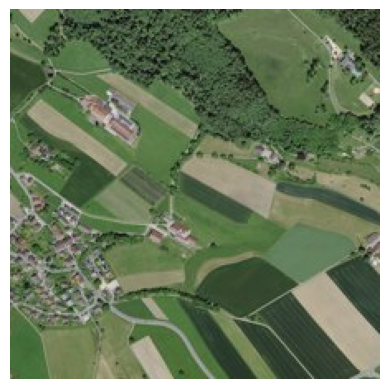

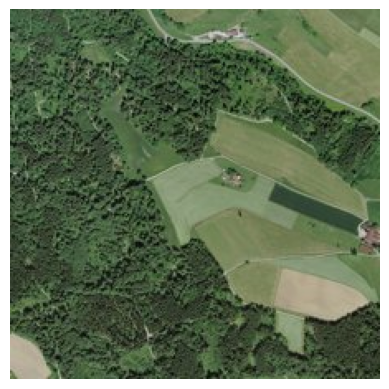

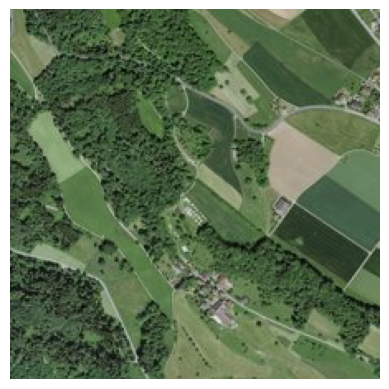

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display the first few images
for i in range(3):
    display_image(f'/mnt/data/compressed_images/image_{i}.jpeg')


In [10]:
import zipfile
import os

# Path to the ZIP file and the directory where you want to extract it
zip_file_path = '/content/labled.zip'
extraction_directory = '/content/extracted_images'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_directory, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print("Extraction Completed.")


Extraction Completed.


In [11]:
# List the first few files in the extraction directory
extracted_files = os.listdir(extraction_directory)
print("Extracted files:", extracted_files[:5])


Extracted files: ['PV01_325123_1204229.bmp', 'PV01_325199_1204170.bmp', 'PV01_325412_1205370_label.bmp', 'PV01_325563_1204534_label.bmp', 'PV01_325326_1205380.bmp']


In [12]:
import os

# Directory containing the extracted images
image_directory = '/content/extracted_images'

# Separating the raw images and their corresponding labels
raw_images = []
label_images = []

for filename in os.listdir(image_directory):
    if filename.endswith('_label.bmp'):
        label_images.append(filename)
    else:
        raw_images.append(filename)

# Just to verify
print("Raw images:", raw_images[:5])
print("Label images:", label_images[:5])


Raw images: ['PV01_325123_1204229.bmp', 'PV01_325199_1204170.bmp', 'PV01_325326_1205380.bmp', 'PV01_325331_1205372.bmp', 'PV01_325334_1203789.bmp']
Label images: ['PV01_325412_1205370_label.bmp', 'PV01_325563_1204534_label.bmp', 'PV01_325194_1204251_label.bmp', 'PV01_324972_1203801_label.bmp', 'PV01_325206_1204181_label.bmp']


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]
)


In [14]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_image(image_path, target_size=(224, 224)):
    image = img_to_array(load_img(image_path, target_size=target_size)) / 255.0
    return image

# Assuming extraction_directory is correctly set
preprocessed_images = [preprocess_image(os.path.join(extraction_directory, img)) for img in raw_images]
preprocessed_labels = [preprocess_image(os.path.join(extraction_directory, lbl)) for lbl in label_images]


In [15]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    preprocessed_images, preprocessed_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42)


In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(224, 224, 3)):
    inputs = Input(input_size)

    # Contracting Path (Downsampling)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path (Upsampling)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
import numpy as np

def preprocess_label(image_path, target_size=(224, 224)):
    image = img_to_array(load_img(image_path, target_size=target_size, color_mode='grayscale')) / 255.0
    return image

preprocessed_labels = np.array([preprocess_label(os.path.join(extraction_directory, f)) for f in label_images])
print("Label shape:", preprocessed_labels.shape)  # This should output (num_samples, 224, 224, 1)


Label shape: (665, 224, 224, 1)


In [18]:

train_images, val_images, train_labels, val_labels = train_test_split(
    preprocessed_images, preprocessed_labels, test_size=0.25, random_state=42)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image data augmentation generators
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit methods
seed = 1
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_labels, augment=True, seed=seed)


In [20]:
print(f"Number of training images: {len(train_images)}")


Number of training images: 498


In [21]:
batch_size = 32  # Adjust as necessary
steps_per_epoch = max(1, len(train_images) // batch_size)
print(f"Steps per epoch: {steps_per_epoch}")


Steps per epoch: 15


In [22]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training labels: {len(train_labels)}")


Number of training images: 498
Number of training labels: 498


In [23]:
import numpy as np

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)


Shape of train_images: (498, 224, 224, 3)
Shape of train_labels: (498, 224, 224, 1)


In [24]:
batch_size = 5  # or 3
steps_per_epoch = max(1, len(train_images) // batch_size)
print(f"Batch size: {batch_size}, Steps per epoch: {steps_per_epoch}")


Batch size: 5, Steps per epoch: 99


In [25]:
val_images = np.array(val_images)
val_labels = np.array(val_labels)


In [26]:
print(f"Number of validation images: {len(val_images)}")
print(f"Number of validation labels: {len(val_labels)}")


Number of validation images: 167
Number of validation labels: 167


In [27]:
val_images = np.array(val_images)
val_labels = np.array(val_labels)

print("Shape of val_images:", val_images.shape)
print("Shape of val_labels:", val_labels.shape)


Shape of val_images: (167, 224, 224, 3)
Shape of val_labels: (167, 224, 224, 1)


In [28]:
history = model.fit(
    image_datagen.flow(train_images, train_labels, batch_size=batch_size, seed=seed),
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Adjust as necessary
    validation_data=(val_images, val_labels)
)


Epoch 1/50
99/99 [==============================] - 27s 143ms/step - loss: 0.5790 - accuracy: 0.6913 - val_loss: 0.5683 - val_accuracy: 0.6974
Epoch 2/50
99/99 [==============================] - 6s 56ms/step - loss: 0.5640 - accuracy: 0.7041 - val_loss: 0.5666 - val_accuracy: 0.6974
Epoch 3/50
99/99 [==============================] - 6s 57ms/step - loss: 0.5635 - accuracy: 0.7037 - val_loss: 0.5741 - val_accuracy: 0.6974
Epoch 4/50
99/99 [==============================] - 6s 58ms/step - loss: 0.5608 - accuracy: 0.7047 - val_loss: 0.5626 - val_accuracy: 0.6974
Epoch 5/50
99/99 [==============================] - 6s 60ms/step - loss: 0.5567 - accuracy: 0.7063 - val_loss: 0.5624 - val_accuracy: 0.6974
Epoch 6/50
99/99 [==============================] - 6s 62ms/step - loss: 0.5558 - accuracy: 0.7042 - val_loss: 0.5663 - val_accuracy: 0.6974
Epoch 7/50
99/99 [==============================] - 6s 61ms/step - loss: 0.5587 - accuracy: 0.7038 - val_loss: 0.5628 - val_accuracy: 0.6974
Epoch 8/50


In [29]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)


Shape of test_images: (133, 224, 224, 3)
Shape of test_labels: (133, 224, 224, 3)


In [30]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


5/5 [==============================] - 1s 69ms/step - loss: 0.5571 - accuracy: 0.7019
Test Loss: 0.5571029186248779, Test Accuracy: 0.7019079327583313


In [31]:
model.save('my_model.h5')  # Saves the model for future use


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


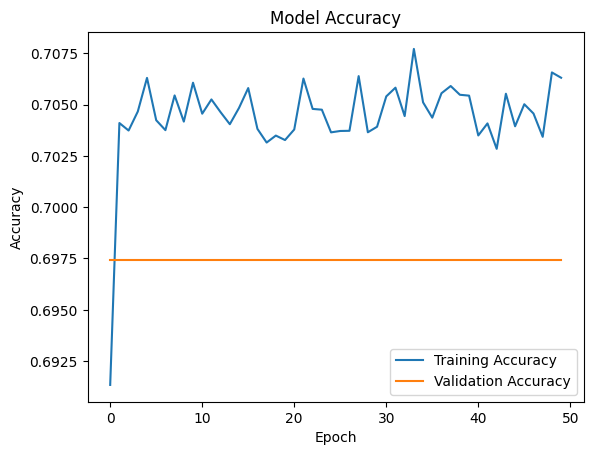

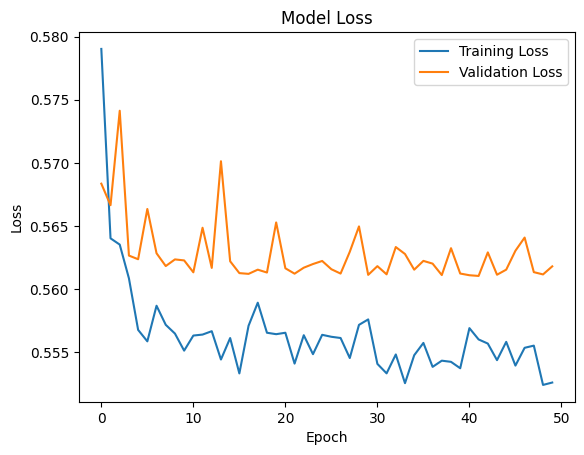

In [32]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


1/1 [==============================] - 0s 274ms/step


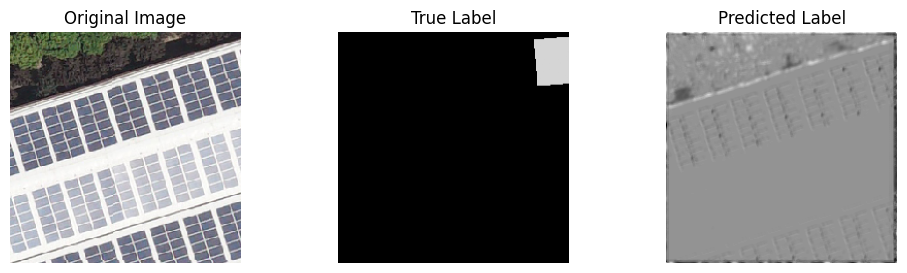

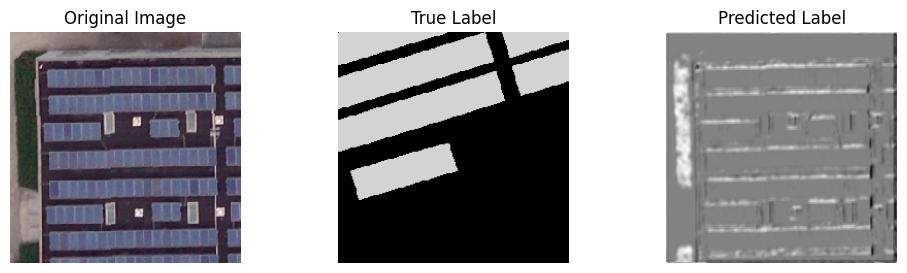

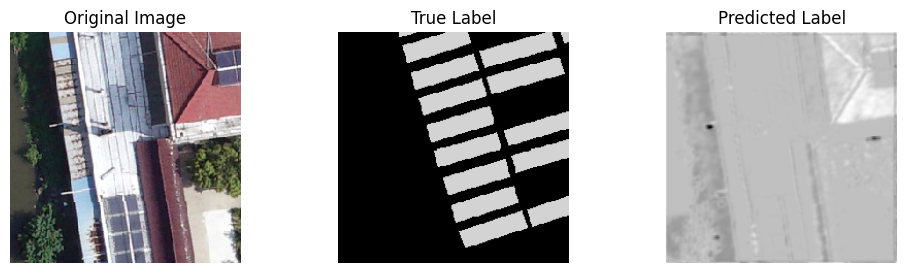

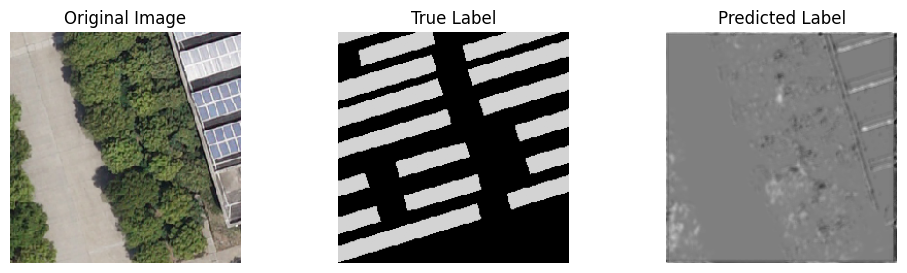

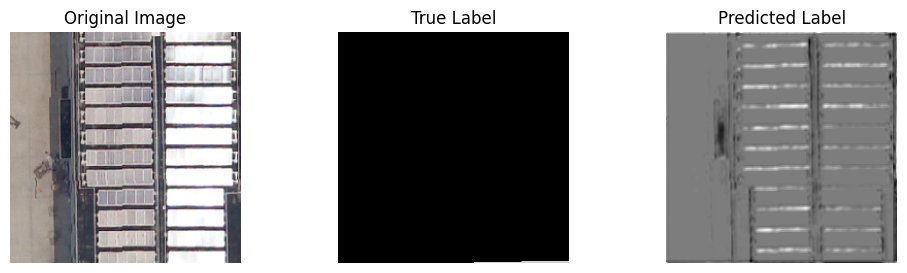

In [33]:
import matplotlib.pyplot as plt

# Select a few images from your test set
test_sample_images = test_images[:5]
test_sample_labels = test_labels[:5]

predicted_labels = model.predict(test_sample_images)

for i in range(len(test_sample_images)):
    plt.figure(figsize=(12, 3))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_sample_images[i])
    plt.title("Original Image")
    plt.axis('off')

    # Display true label (mask)
    plt.subplot(1, 3, 2)
    plt.imshow(test_sample_labels[i].squeeze(), cmap='gray')
    plt.title("True Label")
    plt.axis('off')

    # Display predicted label (mask)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_labels[i].squeeze(), cmap='gray')
    plt.title("Predicted Label")
    plt.axis('off')

    plt.show()


In [34]:
# Get the predictions from the model
predictions = model.predict(test_images)

# Check the shape of the predictions and the true labels
print("Predictions shape:", predictions.shape)
print("True labels shape:", test_labels.shape)

# Flatten the predictions and the true labels
y_pred = predictions.flatten()
y_true = test_labels.flatten()

# Apply a threshold to convert probabilities to binary values
y_pred = (y_pred > 0.5).astype(int)

# Verify that the flattened arrays have the same length
print("Flattened predictions length:", y_pred.shape)
print("Flattened true labels length:", y_true.shape)

# If the lengths match, calculate the metrics
if y_pred.shape == y_true.shape:
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)

    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, IoU: {iou}")
else:
    print("The predictions and true labels have different lengths.")


5/5 [==============================] - 0s 73ms/step
Predictions shape: (133, 224, 224, 1)
True labels shape: (133, 224, 224, 3)
Flattened predictions length: (6673408,)
Flattened true labels length: (20020224,)
The predictions and true labels have different lengths.


In [35]:
from tensorflow.keras.optimizers import Adam

# Example of trying a different learning rate
new_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=new_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


In [36]:
data_gen_args = {
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'vertical_flip': True,  # New augmentation
    'brightness_range': [0.8, 1.2],  # New augmentation
    'fill_mode': 'nearest'
}

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit methods
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_labels, augment=True, seed=seed)


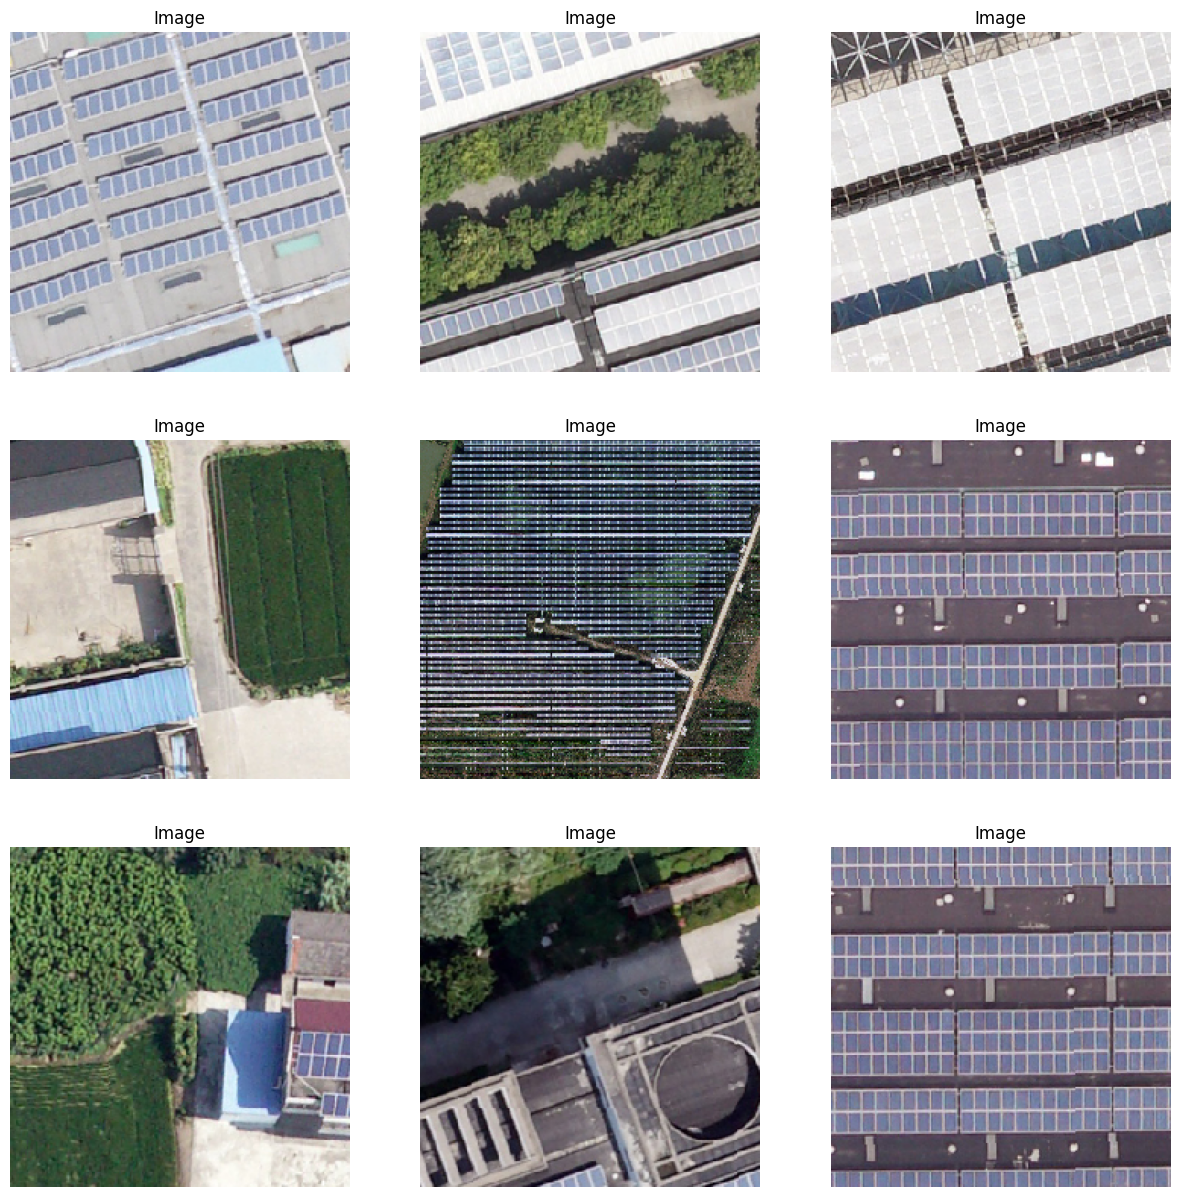

In [37]:
import matplotlib.pyplot as plt

# Assuming 'train_images' is your dataset of images
def plot_image_samples(images, titles, rows=3, cols=3, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    for i in range(1, cols * rows + 1):
        plt.subplot(rows, cols, i)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Plotting a sample of images
plot_image_samples(train_images, titles=["Image" for _ in train_images])


In [38]:
from tensorflow.keras.optimizers import Adam

# Example: trying different learning rates
learning_rates = [0.01, 0.001, 0.0001]
for lr in learning_rates:
    model = unet_model()
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    # Train your model
    history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(val_images, val_labels))

    # Optionally, you can evaluate the model here or save the training history for later analysis
    print(f"Training with learning rate: {lr}")
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/10
16/16 [==============================] - 25s 783ms/step - loss: 8.1285 - accuracy: 0.5415 - val_loss: 0.5717 - val_accuracy: 0.6974
Epoch 2/10
16/16 [==============================] - 5s 291ms/step - loss: 1.9355 - accuracy: 0.6871 - val_loss: 0.5702 - val_accuracy: 0.6974
Epoch 3/10
16/16 [==============================] - 5s 287ms/step - loss: 0.5699 - accuracy: 0.7048 - val_loss: 0.5691 - val_accuracy: 0.6974
Epoch 4/10
16/16 [==============================] - 5s 286ms/step - loss: 0.5634 - accuracy: 0.7048 - val_loss: 0.5662 - val_accuracy: 0.6974
Epoch 5/10
16/16 [==============================] - 5s 285ms/step - loss: 0.5609 - accuracy: 0.7048 - val_loss: 0.5626 - val_accuracy: 0.6974
Epoch 6/10
16/16 [==============================] - 5s 285ms/step - loss: 0.5576 - accuracy: 0.7048 - val_loss: 0.5626 - val_accuracy: 0.6974
Epoch 7/10
16/16 [==============================] - 5s 284ms/step - loss: 0.5585 - accuracy: 0.7048 - val_loss: 0.5615 - val_accuracy: 0.6974
Epoch

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

def simple_model(input_shape):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Assuming train_images, train_labels, val_images, val_labels are already defined

# Flatten the images for the simple dense network
train_images_flat = np.array([img.flatten() for img in train_images])
val_images_flat = np.array([img.flatten() for img in val_images])

# Function to reshape labels for binary classification
def reshape_labels(labels):
    reshaped = []
    for label in labels:
        # Flatten the label and use the majority class (0 or 1) as the label for the whole image
        majority_class = np.round(np.mean(label))
        reshaped.append(majority_class)
    return np.array(reshaped)

train_labels_flat = reshape_labels(train_labels)
val_labels_flat = reshape_labels(val_labels)

# Create and compile the model
input_shape = (train_images_flat.shape[1],)  # This is the flattened shape
baseline_model = simple_model(input_shape)
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = baseline_model.fit(
    train_images_flat,
    train_labels_flat,
    batch_size=32,
    epochs=10,
    validation_data=(val_images_flat, val_labels_flat)
)

# Evaluate the model on the validation set
val_loss, val_accuracy = baseline_model.evaluate(val_images_flat, val_labels_flat)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Epoch 1/10
16/16 [==============================] - 2s 40ms/step - loss: 15.5995 - accuracy: 0.7711 - val_loss: 8.3769 - val_accuracy: 0.8443
Epoch 2/10
16/16 [==============================] - 0s 18ms/step - loss: 6.5955 - accuracy: 0.7590 - val_loss: 12.1249 - val_accuracy: 0.8443
Epoch 3/10
16/16 [==============================] - 0s 18ms/step - loss: 6.5641 - accuracy: 0.7711 - val_loss: 5.3331 - val_accuracy: 0.8443
Epoch 4/10
16/16 [==============================] - 0s 18ms/step - loss: 6.4449 - accuracy: 0.8173 - val_loss: 23.8018 - val_accuracy: 0.1557
Epoch 5/10
16/16 [==============================] - 0s 18ms/step - loss: 17.2829 - accuracy: 0.7791 - val_loss: 17.8326 - val_accuracy: 0.1557
Epoch 6/10
16/16 [==============================] - 0s 17ms/step - loss: 11.7949 - accuracy: 0.7028 - val_loss: 6.3020 - val_accuracy: 0.8443
Epoch 7/10
16/16 [==============================] - 0s 18ms/step - loss: 9.8836 - accuracy: 0.7972 - val_loss: 9.9530 - val_accuracy: 0.8443
Epoch 8

1/1 [==============================] - 0s 250ms/step


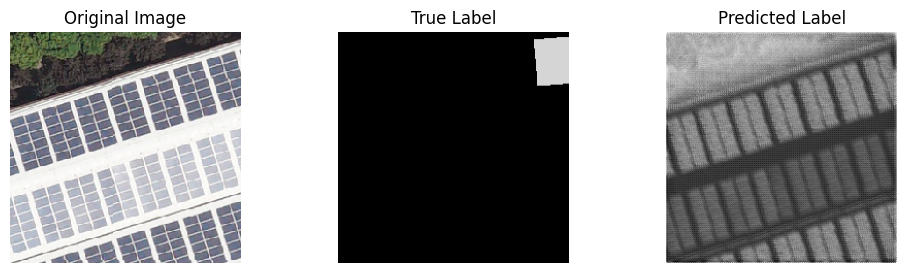

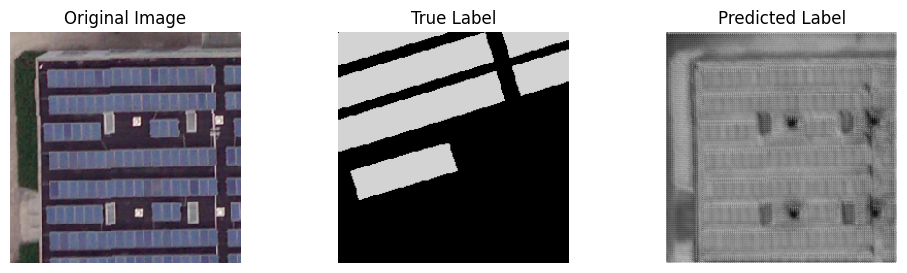

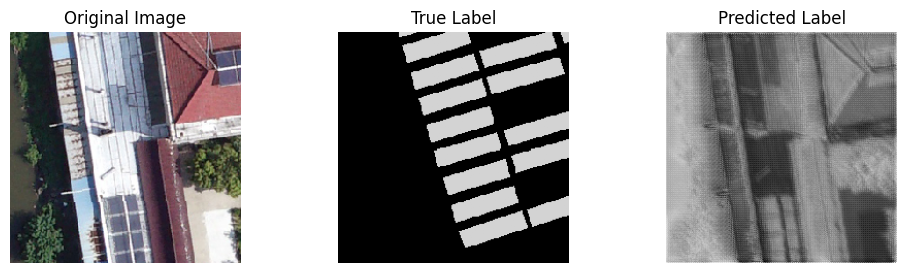

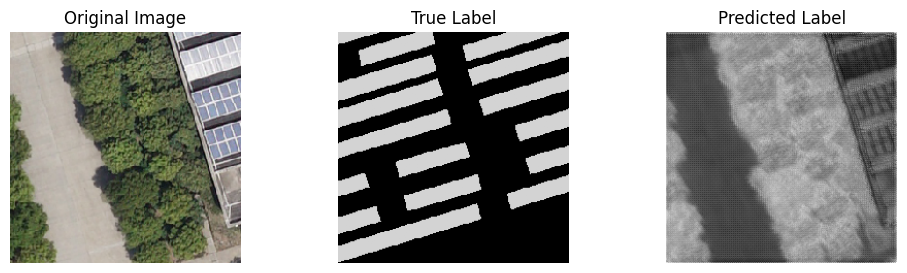

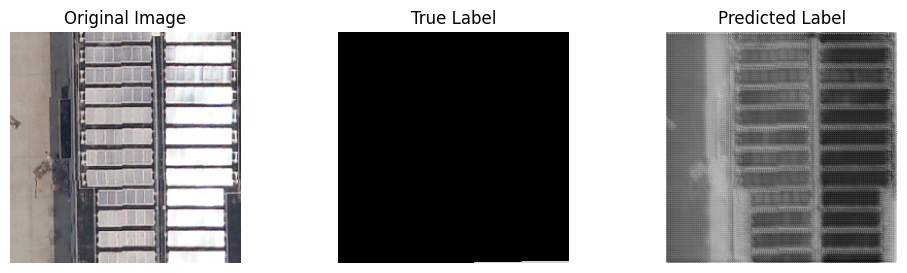

In [40]:
import matplotlib.pyplot as plt

# Select a few images from your test set
test_sample_images = test_images[:5]
test_sample_labels = test_labels[:5]

predicted_labels = model.predict(test_sample_images)

for i in range(len(test_sample_images)):
    plt.figure(figsize=(12, 3))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_sample_images[i])
    plt.title("Original Image")
    plt.axis('off')

    # Display true label (mask)
    plt.subplot(1, 3, 2)
    plt.imshow(test_sample_labels[i].squeeze(), cmap='gray')
    plt.title("True Label")
    plt.axis('off')

    # Display predicted label (mask)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_labels[i].squeeze(), cmap='gray')
    plt.title("Predicted Label")
    plt.axis('off')

    plt.show()


In [41]:
pip install gradio


In [ ]:
pip install --upgrade typing_extensions


In [42]:
pip install --upgrade gradio


In [43]:
import sys
print(sys.version)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [45]:
!pip install --force-reinstall gradio


  Using cached gradio-4.16.0-py3-none-any.whl (16.7 MB)
  Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 kB 11.6 MB/s eta 0:00:00
  Using cached fastapi-0.109.0-py3-none-any.whl (92 kB)
  Using cached ffmpy-0.3.1-py3-none-any.whl
  Using cached gradio_client-0.8.1-py3-none-any.whl (305 kB)
  Using cached httpx-0.26.0-py3-none-any.whl (75 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 73.5 MB/s eta 0:00:00
  Using cached orjson-3.9.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (139 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 98.9 MB/s eta 0:00:00
     

In [2]:
import gradio as gr
import numpy as np

def predict_image(img):
    # Replace 'preprocess_image' with your actual preprocessing function
    processed_img = preprocess_image(img)
    prediction = model.predict(np.array([processed_img]))[0]
    return prediction

iface = gr.Interface(fn=predict_image, inputs=gr.inputs.Image(shape=(224, 224)), outputs='image')
iface.launch()


AttributeError: module 'gradio' has no attribute 'inputs'